# Presentation of new pyALF features

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF:

In [1]:
%matplotlib Notebook
import os
import numpy as np
from py_alf import Simulation              # Interface with ALF

**2.** Create an instance of `Simulation`, setting parameters as desired:

**New:** Proper support for Parallel Tempering

In [2]:
sim = Simulation(
    "Hubbard",
    [{
        'L1': 4,
        'L2': 4,
        "Nsweep": 1,
        "Nbin": 1000,
        "Lattice_type": "Square",
        "Ham_U": U,
        "mpi_per_parameter_set": 1
    } for U in [1, 2, 3, 4]
    ],
    n_mpi=4,
    alf_dir=os.getenv('ALF_DIR', './ALF'),
    machine='intel'
)

**3.** Compile ALF, downloading it first from the [ALF repository](https://git.physik.uni-wuerzburg.de:ALF) if not found locally. This may take a few minutes:

In [17]:
sim.compile()

Compiling ALF... Done.


**4.** Perform the simulation as specified in `sim`:

In [13]:
sim.run()

Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1" for Monte Carlo run.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0" for Monte Carlo run.
Resuming previous run.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1" for Monte Carlo run.
Resuming previous run.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2" for Monte Carlo run.
Resuming previous run.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3" for Monte Carlo run.
Resuming previous run.
Run /home/jonas/Programs/ALF/Prog/ALF.out


**New:** Derived observables

In [5]:
def obs_squared(obs, sign, N_obs):
    return obs**2 / sign

# Energy squared
sim.custom_obs['E_squared']= {
    'needs': ['Ener_scal'],
    'function': obs_squared,
    'kwargs': {}
}

In [3]:
def E_pot_kin(E_pot_obs, E_pot_sign, E_pot_N_obs, E_kin_obs, E_kin_sign, E_kin_N_obs):
    return E_pot_obs/E_kin_obs / (E_pot_sign/E_kin_sign)

# Potential Energy / Kinetic Energy
sim.custom_obs['E_pot_kin']= {
    'needs': ['Pot_scal', 'Kin_scal'],
    'function': E_pot_kin,
    'kwargs': {}
}

In [11]:
def R_k(obs, back, sign, N_orb, N_tau, dtau, latt, ks=[[0., 0.]], mat=None):
    """RG-invariant quantity derived from a correlatian function.
    
    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    if mat is None:
        mat = np.identity(N_orb)
    out = 0
    for k in ks:
        n = latt.k_to_n(k)

        J1 = (obs[..., n].sum(axis=-1) * mat).sum()
        J2 = 0
        for i in latt.NNk(n):
            J2 = J2 + (obs[..., i].sum(axis=-1) * mat).sum() / len(latt.NNk(n))
        out += (1 - J2/J1)

    return out / len(ks)

# RG-invariant quantity for ferromagnetic order
sim.custom_obs['R_Ferro']= {
    'needs': ['SpinZ_eq'],
    'function': R_k,
    'kwargs': {'ks': [[0., 0.]]}
}

# RG-invariant quantity for antiferromagnetic order
sim.custom_obs['R_AFM']= {
    'needs': ['SpinZ_eq'],
    'function': R_k,
    'kwargs': {'ks': [[np.pi, np.pi]]}
}

**New:** Check warmup and autocorrelation

<IPython.core.display.Javascript object>


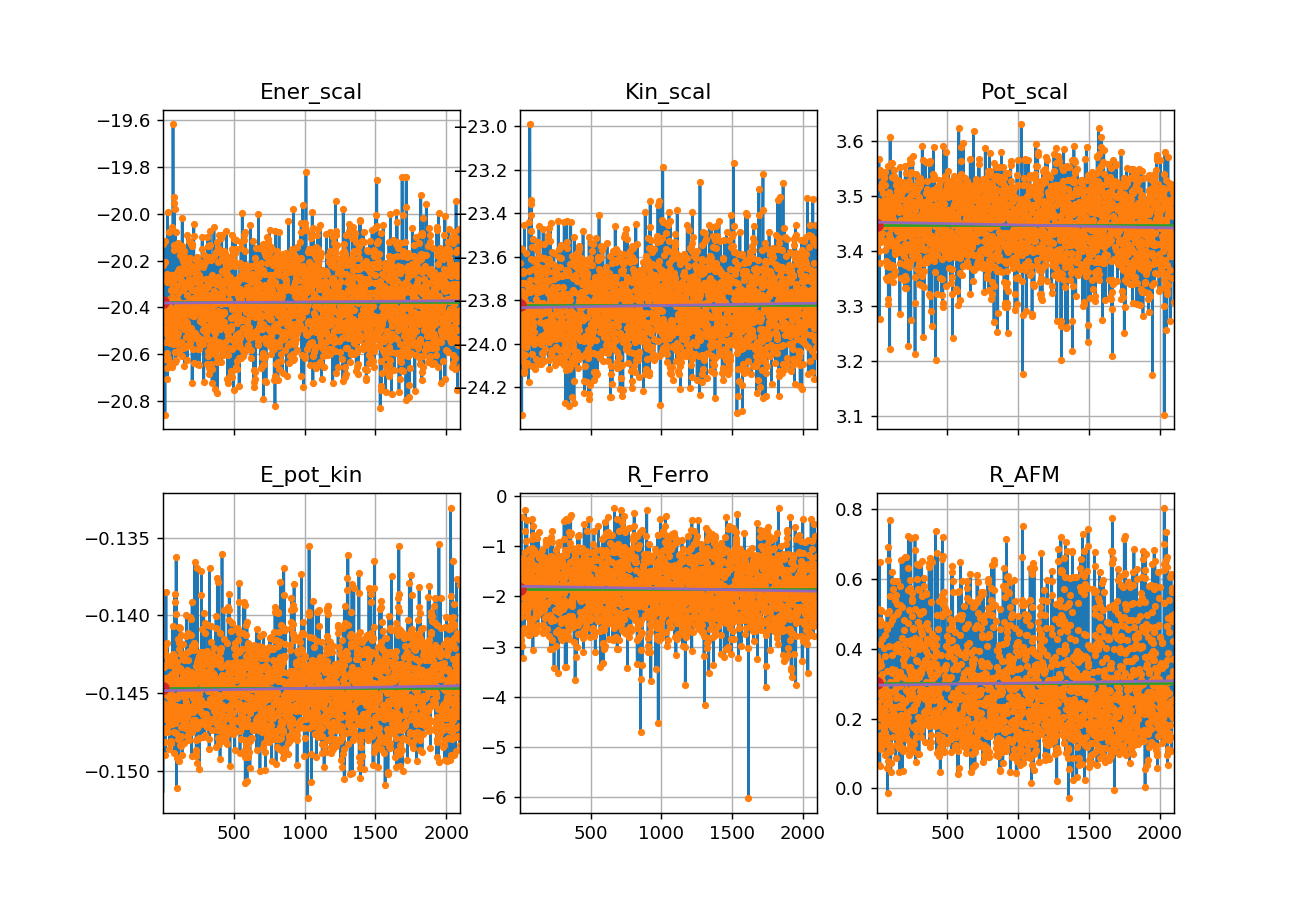

Ener_scal
Kin_scal
Pot_scal
custom E_pot_kin
custom R_Ferro
custom R_AFM


/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-20.37636387724788+0j) (-2.3439135663706398e-07-0j)
(-23.823285164493893+0j) (-4.0890434477073666e-07-0j)
(3.4469212872460147+0j) (-1.4405328713753706e-06+0j)
-0.14468632684741037 -1.0345590367450778e-06
-1.8447540274486351 2.5757324824581757e-05
0.3021710671009219 1.9878135637402367e-05


In [12]:
sim.check_warmup(['Ener_scal', 'Kin_scal', 'Pot_scal', 'E_pot_kin', 'R_Ferro', 'R_AFM'])

<IPython.core.display.Javascript object>


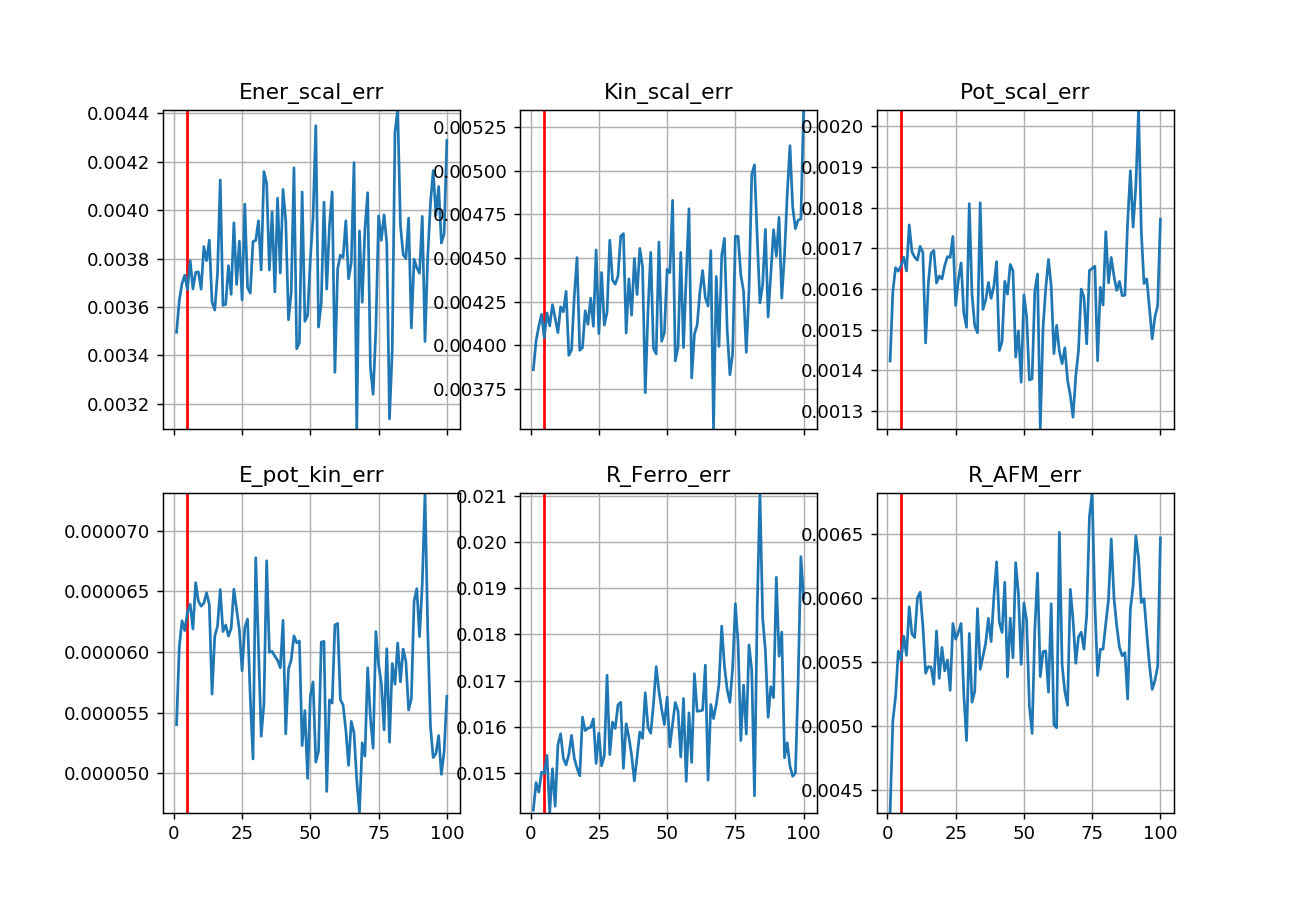

Ener_scal
Kin_scal
Pot_scal
custom E_pot_kin
2099
1049
699
524
419
349
299
262
233
209
190
174
161
149
139
131
123
116
110
104
99
95
91
87
83
80
77
74
72
69
67
65
63
61
59
58
56
55
53
52
51
49
48
47
46
45
44
43
42
41
41
40
39
38
38
37
36
36
35
34
34
33
33
32
32
31
31
30
30
29
29
29
28
28
27
27
27
26
26
26
25
25
25
24
24
24
24
23
23
23
23
22
22
22
22
21
21
21
21
20
[5.40114184e-05 6.04213231e-05 6.25864818e-05 6.17722848e-05
 6.33171576e-05 6.39408554e-05 6.18989142e-05 6.57265051e-05
 6.41898968e-05 6.37846946e-05 6.40452328e-05 6.48967090e-05
 6.39189560e-05 5.65306829e-05 6.13163599e-05 6.21268668e-05
 6.51638707e-05 6.16981525e-05 6.22278314e-05 6.13180468e-05
 6.19534571e-05 6.51849577e-05 6.35266972e-05 6.18325904e-05
 5.84526056e-05 6.20202215e-05 6.27208093e-05 5.62300220e-05
 5.11738159e-05 6.77815964e-05 6.04732959e-05 5.30481423e-05
 5.57314363e-05 6.75291053e-05 5.99703485e-05 6.00570777e-05
 5.96591259e-05 5.93227345e-05 5.87022626e-05 6.26231301e-05
 5.32465397e-05 5.86058

In [13]:
sim.check_rebin(['Ener_scal', 'Kin_scal', 'Pot_scal', 'E_pot_kin', 'R_Ferro', 'R_AFM'])

**New:** Lattice symmetries in analysis

In [7]:
# Define list of transformations (Lattice, i) -> new_i
# Default analysis will average over all listed elements
def sym_c4_0(latt, i): return i
def sym_c4_1(latt, i): return latt.rotate(i, np.pi*0.5)
def sym_c4_2(latt, i): return latt.rotate(i, np.pi)
def sym_c4_3(latt, i): return latt.rotate(i, np.pi*1.5)

sym_c4 = [sym_c4_0, sym_c4_1, sym_c4_2, sym_c4_3]

**5.** Perform anaylsis:

In [8]:
sim.analysis(symmetry=sym_c4)

### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
Scalar observables:
Acc_Temp_scal
Ener_scal


/home/jonas/Programs/pyALF/alf_ana/ana.py:408: RuntimeWarning: invalid value encountered in true_divide
  J = J_obs[:, n] / J_sign


Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
Scalar observables:
Acc_Temp_scal
Ener_scal


/home/jonas/Programs/pyALF/alf_ana/ana.py:408: RuntimeWarning: invalid value encountered in true_divide
  J = J_obs[:, n] / J_sign


Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observab

**6.** Read analysis results:

In [9]:
obs = sim.get_obs()

/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3


In [10]:
obs

,continuous,ham_chem,ham_t,ham_t2,ham_tperp,ham_u,ham_u2,mz,l1,l2,...,SpinXY_tauK,SpinXY_tauK_err,SpinXY_tauR0,SpinXY_tauR0_err,SpinXY_tau_lattice,SpinZ_tauK,SpinZ_tauK_err,SpinZ_tauR0,SpinZ_tauR0_err,SpinZ_tau_lattice
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0,0,0.0,1.0,1.0,1.0,1.0,4.0,1,4,4,...,"[[0.5759211208839644, 0.4040460904258806, 0.57...","[[0.0005338490587422387, 0.0007955262248789723...","[0.5692569751513998, 0.44515494542932765, 0.35...","[0.0004404766576570506, 0.0009708620010154572,...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.5797160477124357, 0.4035969640248175, 0.57...","[[0.0020899733345038553, 0.0011028544047279, 0...","[0.5692467276158925, 0.4461445386252904, 0.361...","[0.00044051855229152245, 0.0005114692621432856...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1,0,0.0,1.0,1.0,1.0,2.0,4.0,1,4,4,...,"[[0.6285237082221076, 0.42028105818778794, 0.6...","[[0.00235219160402554, 0.0021818787104038615, ...","[0.6333050639299355, 0.5120505460403114, 0.424...","[0.0009565863460546503, 0.002206340545695298, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.635811017404258, 0.41950134224299457, 0.63...","[[0.005023289358576116, 0.002348292538940761, ...","[0.6333020924348345, 0.5119082773360161, 0.426...","[0.0009549187502049825, 0.0010877927282603801,...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2,0,0.0,1.0,1.0,1.0,3.0,4.0,1,4,4,...,"[[0.6748539834702671, 0.44135067891421265, 0.6...","[[0.006210751488141674, 0.005744784876104712, ...","[0.6943649712606412, 0.5783730995391383, 0.495...","[0.0010841617345720021, 0.0036161093925907366,...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6540855990514813, 0.4303176868867545, 0.65...","[[0.0083764522420667, 0.004747417300569672, 0....","[0.6943202113103615, 0.5767710437984747, 0.492...","[0.0010879172430916678, 0.0013512819889865571,...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3,0,0.0,1.0,1.0,1.0,4.0,4.0,1,4,4,...,"[[0.6770864670018011, 0.4433676679233983, 0.67...","[[0.021773647384916897, 0.07024587648603306, 0...","[0.7535988230959929, 0.6449343773564314, 0.556...","[0.002037496151121978, 0.010152251088156193, 0...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6415655966601447, 0.4330980782847468, 0.64...","[[0.012478926523232374, 0.007385891127601704, ...","[0.7535875454418228, 0.6428654136742865, 0.562...","[0.002037539694278971, 0.002241368127323232, 0...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."


which are available for further analyses. For instance, the internal energy of the system (and its error) is accessed by:

In [23]:
obs[['ham_u', 'Ener_scal0', 'Ener_scal0_err', 'Ener_scal_sign', 'E_pot_kin', 'E_pot_kin_err']]

,ham_u,Ener_scal0,Ener_scal0_err,Ener_scal_sign,E_pot_kin,E_pot_kin_err
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0,1.0,-20.376238,0.005493,1.0,-0.144737,0.000077
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1,2.0,-17.417353,0.014821,1.0,-0.251787,0.000503
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2,3.0,-15.051100,0.022578,1.0,-0.326948,0.000965
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3,4.0,-13.212727,0.039180,1.0,-0.372733,0.001767


<IPython.core.display.Javascript object>


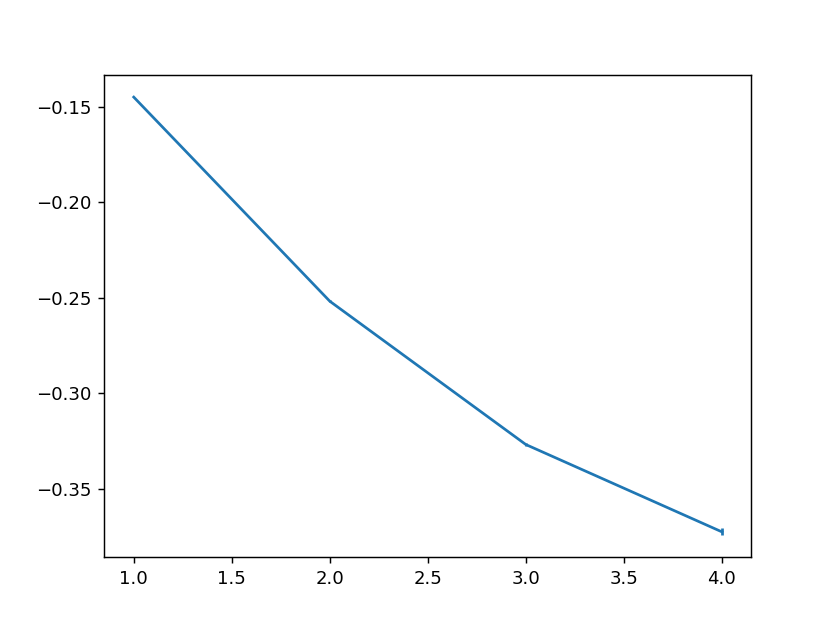

<ErrorbarContainer object of 3 artists>

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(obs.ham_u, obs.E_pot_kin, obs.E_pot_kin_err)

**New:** 2dplot on bravais lattice

In [27]:
from alf_ana.lattice import Lattice

<IPython.core.display.Javascript object>


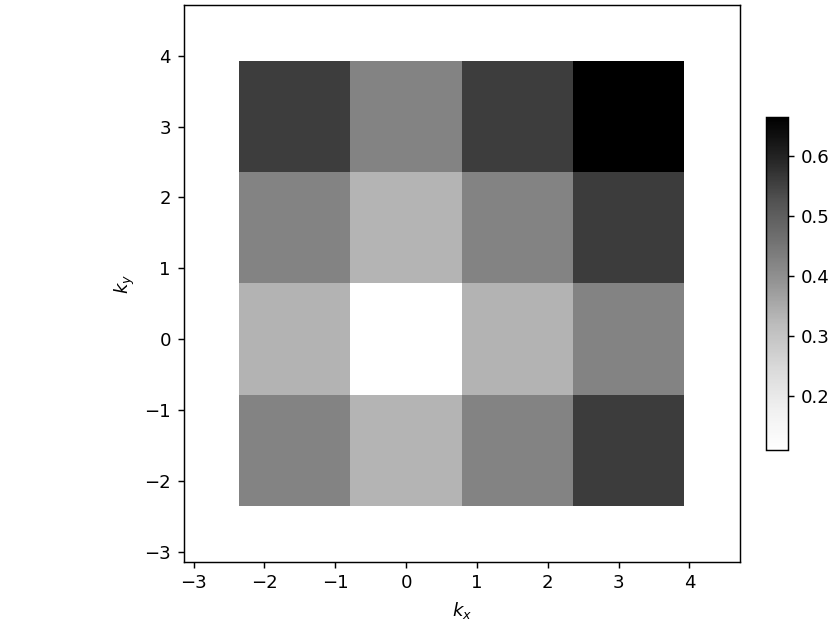

<IPython.core.display.Javascript object>


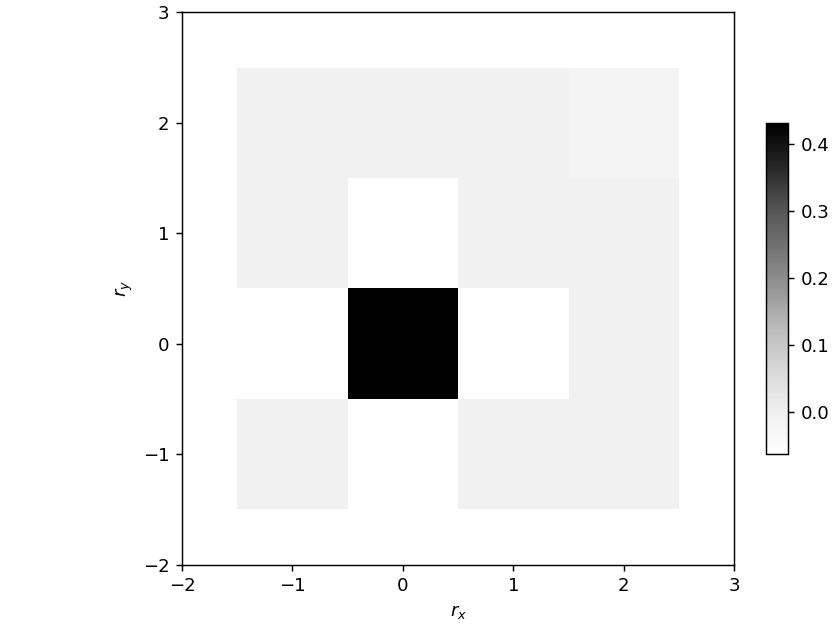

In [28]:
item = obs.iloc[0]

latt = Lattice(item.Den_eq_lattice)

latt.plot_k(item.Den_eqK[0, 0])
latt.plot_r(item.Den_eqR[0, 0])

**Next:**
- Retrieve default parameters from ALF 
- Conveniently display parameters
- Update and improve documentation
- Predefined paths in k-space for plotting (Are there already good libraries we can use for this?)